In [1]:
from helper import Helper
import statsmodels.api as sm

header, train = Helper.load_csv_to_ndarray('data/hw2p5_train.csv')
header, test = Helper.load_csv_to_ndarray('data/hw2p5_test.csv')

x_train = train[:, 1]
y_train = train[:, 0]

x_test = test[:, 1]
y_test = test[:, 0]

assert x_train[0] == 3.1472
assert y_train[0] == 4.7123
assert x_train.shape == (1000,)
assert y_train.shape == (1000,)

assert x_test[0] == -0.97446
assert y_test[0] == -0.37812
assert x_test.shape == (1000,)
assert y_test.shape == (1000,)

In [2]:
from copy import copy
from sklearn.preprocessing import PolynomialFeatures

def create_linear_regression(x_train, y_train, degree):
    if degree == 1:
        return sm.OLS(y_train, sm.add_constant(x_train)).fit()
        
    polynomial_features= PolynomialFeatures(degree=degree)
    # e.g. if degree = 2 and x = (6.0)
    # then x would be -> (6.0, 36.0)
    x_train_modified = polynomial_features.fit_transform(x_train.reshape(-1, 1))
        
    # add intercept so that x = (1.0, 6.0, 36.0)
    x_train_modified = sm.add_constant(x_train_modified)
    
    return sm.OLS(y_train, x_train_modified).fit()

In [3]:
import numpy as np

affine_linear_function = create_linear_regression(x_train, y_train, 1)

print(affine_linear_function.summary())

abs_errors = []
indexes = np.arange(1000)

x_train_with_bias = sm.add_constant(x_train)
y_preds = affine_linear_function.predict(x_train_with_bias)

for i in indexes:
    abs_errors.append(abs(y_preds[i] - y_train[i]))
    
indexes = indexes + 1

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     5815.
Date:                Sat, 05 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:17:36   Log-Likelihood:                -1691.3
No. Observations:                1000   AIC:                             3387.
Df Residuals:                     998   BIC:                             3396.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2403      0.042      5.757      0.0

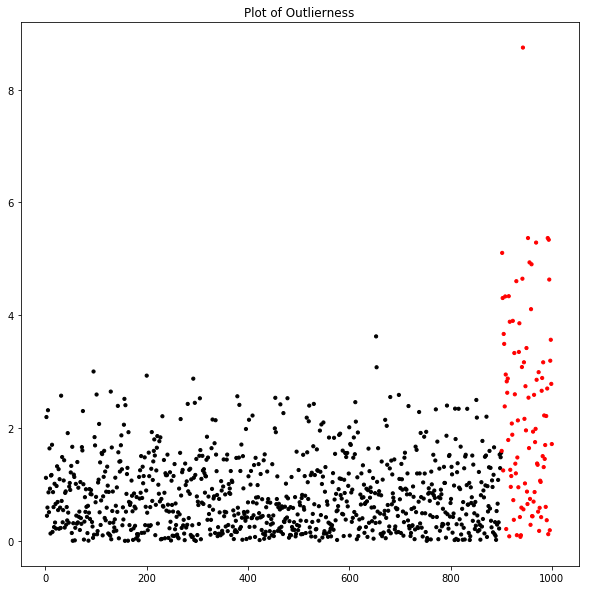

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 10))
plt.title('Plot of Outlierness')

# plt.xlim(-10, 10)
# plt.ylim(-10, 10)

# plt.xticks(np.arange(-10.0, 11.0, 2.5))
# plt.yticks(np.arange(-10.0, 11.0, 2.5))

plt.scatter(indexes[0:900], abs_errors[0:900], color='black', s=np.full(900, 10))
plt.scatter(indexes[900:1000], abs_errors[900:1000], color='red', s=np.full(100, 10))

plt.savefig('q5_outlier_plot.png')
plt.show()

In [5]:
# Calculate test squared error risk

def calculate_squared_loss(prediction_values, label_vector, mean=True):
    # Calculate sigma (y_hat - y)^2
    total_squared_loss = np.sum((prediction_values - label_vector) ** 2)

    # Divide error by total observations to get mean squared loss
    if mean:
        return total_squared_loss / len(label_vector)

    return total_squared_loss

x_test_with_bias = sm.add_constant(x_test)
prediction_values = affine_linear_function.predict(x_test_with_bias)

print(calculate_squared_loss(prediction_values, y_test))

4.034974776250005


In [6]:
# Split into two subpopulations
x_train_f_900 = x_train[0:900]
y_train_f_900 = y_train[0:900]
x_train_l_100 = x_train[900:1000]
y_train_l_100 = y_train[900:1000]

assert np.array_equal(np.concatenate([x_train_f_900, x_train_l_100]), x_train) == True
assert np.array_equal(np.concatenate([y_train_f_900, y_train_l_100]), y_train) == True

In [7]:
# Average 
x_j = np.mean(x_train_f_900)
y_j = np.mean(y_train_f_900)
print(x_j, y_j)

x_k = np.mean(x_train_l_100)
y_k = np.mean(y_train_l_100)
print(x_k, y_k)

# Average of total squared
squared_x_j = np.sum(np.square(x_train_f_900)) / (900)
squared_x_k = np.sum(np.square(x_train_l_100)) / (100)
print(squared_x_j, squared_x_k)

# Average of multiplication
print('ncuk')
x_j_y_j = (np.dot(x_train_f_900, y_train_f_900)) / (900)
x_k_y_k = (np.dot(x_train_l_100, y_train_l_100)) / (100)
print(np.mean(x_j_y_j), x_k_y_k)

-0.13752731371111113 -0.08533406733333333
3.9438372999999998 6.052706000000001
8.077778755169328 16.603636927389
ncuk
8.095984588390834 22.89193073013


In [8]:
top_m = (2 * (x_j_y_j + x_k_y_k)) - ((x_j + x_k) * (y_j + y_k))
bot_m = (2 * (squared_x_j + squared_x_k)) - ((x_j + x_k)**2)
m = top_m / bot_m
print(m)

1.1258021012067874


In [9]:
b = (y_j + y_k) - (m * (x_j + x_k))
b = b / 2
print(b)

0.8411100761291292


In [10]:
# 5c test risk of g
x_test_with_bias = sm.add_constant(x_test)
# print(x_test_with_bias[0])

g_prediction_values = []

for i in range(0, len(x_test_with_bias)):
    prediction_value = m * x_test_with_bias[i][1] + b
    g_prediction_values.append(prediction_value)

print(calculate_squared_loss(g_prediction_values, y_test))

3.642645831591768


In [11]:
# Split test into two subpopulations, each 500
x_test_1 = x_test[0:500]
y_test_1 = y_test[0:500]

x_test_2 = x_test[500:1000]
y_test_2 = y_test[500:1000]

assert x_test_2[0] == x_test[500]
assert np.array_equal(np.concatenate([x_test_1, x_test_2]), x_test) == True
assert np.array_equal(np.concatenate([y_test_1, y_test_2]), y_test) == True

In [12]:
x_test_1_with_bias = sm.add_constant(x_test_1)
x_test_2_with_bias = sm.add_constant(x_test_2)

f_1_prediction_values = affine_linear_function.predict(x_test_1_with_bias)
f_2_prediction_values = affine_linear_function.predict(x_test_2_with_bias)

print(calculate_squared_loss(f_1_prediction_values, y_test_1))
print(calculate_squared_loss(f_2_prediction_values, y_test_2))

1.14655962195859
6.92338993054142


In [13]:
g_1_prediction_values = []
g_2_prediction_values = []

for i in range(0, 500):
    prediction_value_1 = m * x_test_1_with_bias[i][1] + b
    prediction_value_2 = m * x_test_2_with_bias[i][1] + b
    
    g_1_prediction_values.append(prediction_value_1)
    g_2_prediction_values.append(prediction_value_2)

print(calculate_squared_loss(g_1_prediction_values, y_test_1))
print(calculate_squared_loss(g_2_prediction_values, y_test_2))

1.8277141906456527
5.457577472537884


In [14]:
# Sanity check that total test risk should be the average of test risk on pop1 and pop2

print((calculate_squared_loss(g_1_prediction_values, y_test_1) + calculate_squared_loss(g_2_prediction_values, y_test_2))/2)
print(calculate_squared_loss(g_prediction_values, y_test))

print((calculate_squared_loss(f_1_prediction_values, y_test_1) + calculate_squared_loss(f_2_prediction_values, y_test_2))/2)
print(calculate_squared_loss(prediction_values, y_test))

3.6426458315917682
3.642645831591768
4.034974776250005
4.034974776250005


In [15]:
# 5e fit model for each subpop
h_1_model = create_linear_regression(x_train_f_900, y_train_f_900, 1)
h_2_model = create_linear_regression(x_train_l_100, y_train_l_100, 1)

h_1_prediction_values = h_1_model.predict(x_test_1_with_bias)
h_2_prediction_values = h_2_model.predict(x_test_2_with_bias)

print(calculate_squared_loss(h_1_prediction_values, y_test_1))
print(calculate_squared_loss(h_2_prediction_values, y_test_2))

1.0840055002248241
1.015860502522174


In [16]:
print(h_1_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     7222.
Date:                Sat, 05 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:17:37   Log-Likelihood:                -1280.8
No. Observations:                 900   AIC:                             2566.
Df Residuals:                     898   BIC:                             2575.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0526      0.034      1.569      0.1

In [17]:
print(h_2_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     110.3
Date:                Sat, 05 Oct 2019   Prob (F-statistic):           9.91e-18
Time:                        16:17:37   Log-Likelihood:                -131.44
No. Observations:                 100   AIC:                             266.9
Df Residuals:                      98   BIC:                             272.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7305      0.362     26.891      0.0